Figure 3 analysis
Performing ARU-E (Extractin part) showing that from robust FAT model we can obtain non-robust model

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 20
exp = "fakenewsnet"

# Load models for FAT and FedAvg - write down path to where weights are saved
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FAT/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FedAvg/'
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 0.1
eps_train = 0.2
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator_og
except:
    aggregator_og, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_og, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator_og, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 95%|█████████▌| 19/20 [00:01<00:00, 16.95it/s]


===> Initializing clients..


100%|██████████| 20/20 [00:00<00:00, 20.31it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(tor

In [12]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 20
num_users = [1,3,5,10]

test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.5
cutoff_round = 5


# save_path_FAT150 = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT_R50/'

for num_user in num_users:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp)

    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    # Test performance of aggregator on data 
    # aggregator.load_state(dir_path=save_path_FAT)
    aggregator.update_clients()
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()

    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator_og, model_FAT, eps = eps_attack, step_size = step_size, steps = steps)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = steps,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.01, step_norm = "inf", eps = eps_train, eps_norm = 2)
    
    #  Assign proportion and attack params
    if False:
        for c in aggregator.clients:
            c.unlearning_flag = True
            
        for i in range(len(aggregator.clients)):
            aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
            aggregator.clients[i].update_advnn()
            aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%1 == 0:
            
            # if round <= cutoff_round:
            #     for i in range(len(aggregator.clients)):
            #         aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
            #         aggregator.clients[i].update_advnn()
            #         aggregator.clients[i].assign_advdataset()
            # else:
            #     for i in range(len(aggregator.clients)):
            #         aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator_og, model_overfit, eps = eps_attack, step_size = step_size, steps = steps)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_
    gc.collect()
    torch.cuda.empty_cache()


==> Clients initialization..
===> Building data iterators..


  0%|          | 0/20 [00:00<?, ?it/s]


===> Initializing clients..


100%|██████████| 1/1 [00:00<00:00, 31.82it/s]


round 0 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 1 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 2 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 3 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 4 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 5 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 6 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 7 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 8 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) a

 10%|█         | 2/20 [00:00<00:01, 13.12it/s]


===> Initializing clients..


100%|██████████| 3/3 [00:00<00:00, 42.60it/s]


round 0 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 1 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 2 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 3 Test acc:  0.517142866551876 ( 0.06334228679722777 ) adv acc:  0.40214286297559737 ( 0.046571206689005426 )
round 4 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 5 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 6 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 7 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 8 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv ac

 20%|██        | 4/20 [00:00<00:01, 13.89it/s]


===> Initializing clients..


100%|██████████| 5/5 [00:00<00:00, 40.11it/s]


round 0 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 1 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 2 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 3 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 4 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 5 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 6 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5114285811781883 ( 0.06414270200166078 )
round 7 Test acc:  0.5157142952084541 ( 0.06306783283290204 ) adv acc:  0.45642857998609543 ( 0.04917171488098732 )
round 8 Test acc:  0.5314285784959794 ( 0.06633249852850409 ) adv acc:  0.251

 45%|████▌     | 9/20 [00:00<00:00, 16.03it/s]


===> Initializing clients..


100%|██████████| 10/10 [00:00<00:00, 41.95it/s]


round 0 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 1 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 2 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 3 Test acc:  0.5150000095367432 ( 0.06396348215803313 ) adv acc:  0.5150000095367432 ( 0.06396348215803313 )
round 4 Test acc:  0.48500000685453415 ( 0.06396347967863475 ) adv acc:  0.48500000685453415 ( 0.06396347967863475 )
round 5 Test acc:  0.54785715341568 ( 0.05292949159788495 ) adv acc:  0.10500000286847352 ( 0.04122486987087031 )
round 6 Test acc:  0.6114285796880722 ( 0.0683030415219696 ) adv acc:  0.025714286090806126 ( 0.023733211674059722 )
round 7 Test acc:  0.632142859697342 ( 0.0702582676091894 ) adv acc:  0.016428571613505482 ( 0.015827514391211512 )
round 8 Test acc:  0.632857146859169 ( 0.0627759210642621 ) adv acc:  0.01

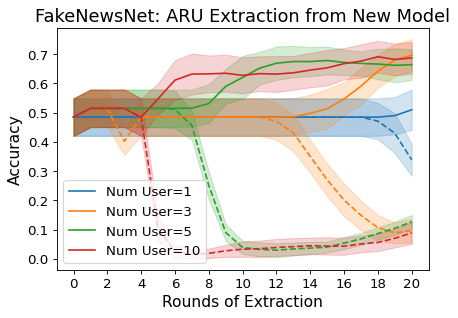

In [19]:

# Initialize a new figure
plt.figure(figsize=(6, 4), dpi=80)

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 21, 1)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    if i < 0:
        continue

    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('FakeNewsNet: ARU Extraction from New Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(np.arange(min(x_values), max(x_values) + 1, 2))  # Ensure whole number ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()